<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Redes neuronales recurrentes con Keras


<u>Consideraciones generales</u>:

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales.

Para esta PEC se ha seleccionado dos series con datos recurrentes de la FRED (Federal Reserve Economic Data). Por un lado tenemos la variable fecha, por otro el Índice de Sentimiento del Consumidor de la Universidad de Michigan. Este índice es una medida de la confianza que tienen los consumidores en la economía de los Estados Unidos. Se basa en encuestas en las que se pregunta a los consumidores sobre sus percepciones y actitudes actuales hacia las finanzas personales, las condiciones económicas generales y las intenciones de compra de bienes duraderos. Los valores altos indican un mayor nivel de confianza del consumidor, lo que generalmente se considera positivo para el gasto del consumidor y, por ende, para la economía. La tercera variable va a ser Producción Industrial. Esta serie mide la producción real de todas las instalaciones ubicadas en el sector manufacturero de los EE. UU. según el Sistema de Clasificación de la Industria de América del Norte (NAICS). Es un indicador importante de la salud económica, ya que refleja el nivel de actividad de las fábricas, minas y servicios públicos. Un aumento en la producción industrial sugiere un crecimiento económico, mientras que una disminución puede indicar una contracción económica.

Nuestra tarea final es la predicción de la tendencia a futuro teniendo la información de ambas gráficas.

Los objetivos de la práctica son:

*   Interpretanción de los datos disponibles, limpieza y normalizado.
*   Creación de un modelo de predicción basado en una GRU, RNN y LSTM. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca.
*   Una vez tengamos entrenado los modelos. Debemos evaluar los modelos por nuevos datos, identificar la necesidad de re-entrenamiento y evaluar nuestro _performance_ del modelo en un entorno de producción para ser capaz de identificar si está funcionando correctamente.

A continuación, os dejamos inicializadas la serie de librerías que necesitarás instalar para utilizar en esta PEC2.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [7]:
sns.set_style('whitegrid')
np.random.seed(42)

**Importante para guardar vuestros modelos ya entrenados y evitar volver a reentrenarlos cada vez que os desaparezca la sesión online de vuestro servicio Cloud (Google Colab, Kaggle, etc.).**

Podéis utilizar la siguiente ruta:

In [8]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

# 1. Carga de Datos / Análisis / Preprocesado / Visualización

## 1.1. Carga, limpieza y transformación de datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> En este ejercicio debes cargar dos series importantes: el Índice de Sentimiento del Consumidor y la Producción Industrial. Una vez cargados los datos con el código que se proporciona:</p>
  <ul>
     <li>Transforma las columnas <code>ip</code> y <code>sentiment</code> realizando una transformación logarítmica diferencial de un periodo anual de 12 meses. Si existen NaN values, elimínalos.</li>
    <li>Aplica una escala min-max a los datos transformados.</li>
    <li>Visualiza ambas series en un gráfico. Es decir, las series de tiempo originales y transformadas para comparar cómo las transformaciones afectan la distribución y tendencia de los datos.</li>
  </ul>
</div>

In [9]:
# Carga de datos
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2023-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,sentiment,ip
DATE,,
1980-01-01,67.0,45.9070
1980-02-01,66.9,46.9873
1980-03-01,56.5,47.5088
1980-04-01,52.7,46.1199
1980-05-01,51.7,44.7920


In [10]:
# Aplicar la transformación logarítmica diferencial de un periodo anual de 12 meses
df = df.pct_change(12)  # Calcular los cambios porcentuales de 12 meses
df = np.log1p(df)  # Aplicar el logaritmo natural más 1

# Eliminar NaN values
df = df.dropna()

df.head()

,sentiment,ip
DATE,,
1981-01-01,0.063605,-0.026729
1981-02-01,0.000000,-0.030979
1981-03-01,0.162961,-0.021237
1981-04-01,0.317591,0.002605
1981-05-01,0.389215,0.042682


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Aplicar la escala min-max a los datos transformados
df_scaled = scaler.fit_transform(df)

# Convertir el resultado a un DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled.head()

,sentiment,ip
DATE,,
1981-01-01,0.648259,0.466355
1981-02-01,0.579549,0.456195
1981-03-01,0.755588,0.479486
1981-04-01,0.922628,0.536486
1981-05-01,1.000000,0.632300


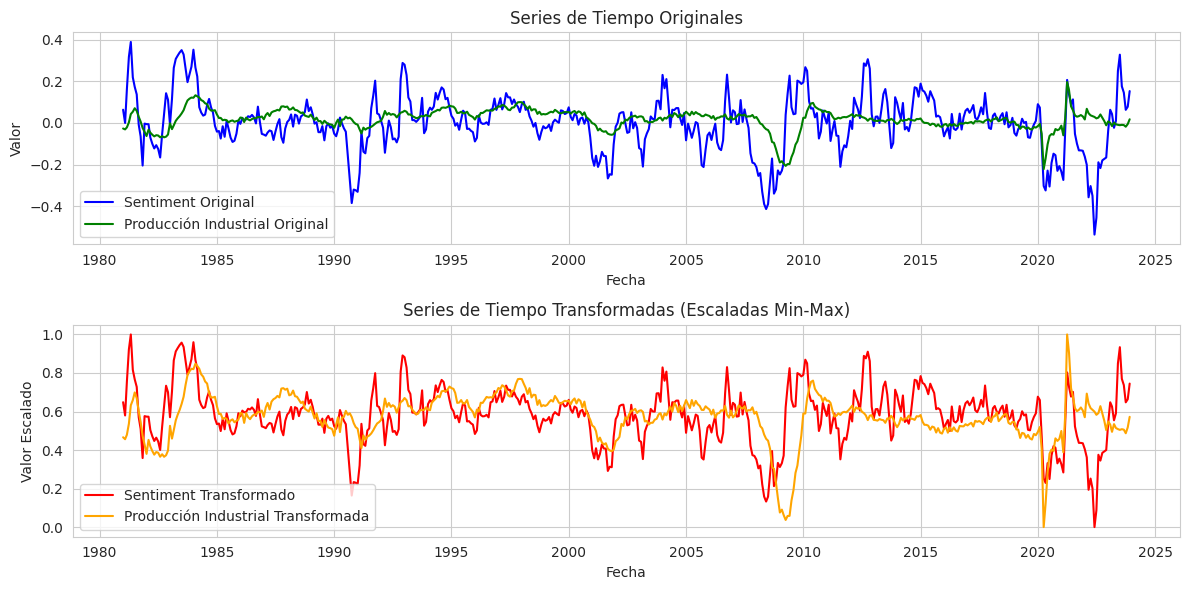

In [12]:
import matplotlib.pyplot as plt

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Visualizar las series de tiempo originales
plt.subplot(2, 1, 1)
plt.plot(df.index, df['sentiment'], label='Sentiment Original', color='blue')
plt.plot(df.index, df['ip'], label='Producción Industrial Original', color='green')
plt.title('Series de Tiempo Originales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Visualizar las series de tiempo transformadas
plt.subplot(2, 1, 2)
plt.plot(df_scaled.index, df_scaled['sentiment'], label='Sentiment Transformado', color='red')
plt.plot(df_scaled.index, df_scaled['ip'], label='Producción Industrial Transformada', color='orange')
plt.title('Series de Tiempo Transformadas (Escaladas Min-Max)')
plt.xlabel('Fecha')
plt.ylabel('Valor Escalado')
plt.legend()

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## 1.2. Preparación de Datos para Modelo Multivariable

Una vez que ya hemos preprocesado los datos, vamos a prepararlos para darle el formato específico que necesita una red recurrente.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Prepara los datos para un modelo de red neuronal recurrente multivariante:</p>
  <ul>
    <li>Define y aplica una función <code>create_multivariate_rnn_data</code> que transforme el conjunto de datos <code>df</code> creado en el ejercicio anterior en un formato adecuado para entrenar un modelo recurrente. La función debe tomar como entrada el conjunto de datos y el tamaño de la ventana (<code>window_size</code>) y devolver una estructura de datos que contenga las secuencias de entrada (<code>X</code>) y las etiquetas objetivo (<code>y</code>).</li>
    <li>Utiliza un <code>window_size</code> de 6 meses para crear tus conjuntos de datos <code>X</code> e <code>y</code>. Verifica las dimensiones de los conjuntos resultantes para asegurarte de que la transformación se haya realizado correctamente.</li>
    <li>Divide los datos transformados en conjuntos de entrenamiento y prueba, utilizando los últimos 24 meses de datos como conjunto de prueba. Asegúrate de que tanto los datos de entrada (<code>X_train</code>, <code>X_test</code>) como las etiquetas (<code>y_train</code>, <code>y_test</code>) estén correctamente particionados.</li>
  </ul>
</div>

In [13]:
# Redacta tu solución aquí
import numpy as np

def create_multivariate_rnn_data(df, window_size):
    """
    Crea secuencias de entrada (X) y etiquetas objetivo (y) para un modelo de red neuronal recurrente multivariante.

    Parámetros:
    - df: DataFrame, conjunto de datos.
    - window_size: int, tamaño de la ventana.

    Retorna:
    - X: array, secuencias de entrada.
    - y: array, etiquetas objetivo.
    """

    # Convertir el DataFrame a una matriz numpy
    data = df.values

    # Inicializar listas para almacenar las secuencias de entrada (X) y las etiquetas objetivo (y)
    X = []
    y = []

    # Crear secuencias de entrada y etiquetas objetivo
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])  # Secuencia de entrada con tamaño window_size
        y.append(data[i+window_size, :])    # Etiqueta objetivo correspondiente

    # Convertir las listas a arrays numpy
    X = np.array(X)
    y = np.array(y)

    return X, y


window_size = 6

# Crear secuencias de entrada (X) y etiquetas objetivo (y)
X, y = create_multivariate_rnn_data(df_scaled, window_size)

# Verificar las dimensiones de las secuencias de entrada y etiquetas objetivo
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (510, 6, 2)
Dimensiones de y: (510, 2)


In [14]:
# Determinar el tamaño del conjunto de prueba (24 meses)
test_size = 24

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)


Dimensiones de X_train: (486, 6, 2)
Dimensiones de X_test: (24, 6, 2)
Dimensiones de y_train: (486, 2)
Dimensiones de y_test: (24, 2)


# 2. Creación del modelo

En este apartado vamos a definir los diferentes modelos y aprenderemos a definir diferentes tipos de redes recurrentes: GRU, RNN y LSTM. En estas además vamos a ir variando sus diferentes parámetros así como sus funciones de pérdida, sus funciones de activación entre capas y otros hiperparámetros.

In [15]:
# Reseteamos la sesión de Keras
K.clear_session()

# Creación de df para comparar 'accuracy' entre modelos
df_accuracy = pd.DataFrame(columns=['Modelo', 'Accuracy'])

## 2.1. RNN

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo de Red Neuronal Recurrente (RNN) simple utilizando Keras. Sigue los pasos para construir la arquitectura del modelo descrita a continuación:</p>
  <ul>
    <li>Define la arquitectura del modelo utilizando la clase <code>Sequential</code> de Keras. Añade una capa <code>SimpleRNN</code> con los parámetros establecidos, incluyendo una tasa de dropout de 0.1 para regularización y evitar el sobreajuste. Asegúrate de que la capa RNN esté configurada para no devolver secuencias, permitiendo una conexión directa a las capas densas posteriores.</li>
    <li>Establece el número de características de entrada (<code>n_features</code>) y el tamaño de salida (<code>output_size</code>) del modelo, ambos fijados en 2, correspondientes a las dos series temporales que se modelarán.</li>
    <li>Configura los hiperparámetros de la red, incluyendo el número de unidades en la capa RNN (<code>rnn_units=12</code>) y el número de unidades en la capa densa (<code>dense_units=6</code>).</li>
    <li>Incluye una capa densa con la activación 'relu' seguida de una capa de salida con la activación 'linear', adecuada para tareas de regresión como la predicción de series temporales.</li>
    <li>Visualiza un resumen del modelo para revisar su estructura y el número total de parámetros entrenables.</li>
    <li>Compila el modelo utilizando 'RMSProp' como optimizador y 'mae' (error absoluto medio) como función de pérdida. Esta configuración es típicamente efectiva para problemas de regresión donde se busca minimizar la diferencia absoluta entre los valores predichos y los valores reales.</li>
  </ul>
</div>

In [17]:
# Solución
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Número de características de entrada y tamaño de salida
n_features = 2
output_size = 2

# Hiperparámetros de la red
rnn_units = 12
dense_units = 6

# Definir la arquitectura del modelo
model = Sequential()

# Capa SimpleRNN
model.add(SimpleRNN(units=rnn_units, input_shape=(None, n_features)))
model.add(Dropout(0.1))  # Tasa de dropout para regularización

# Capa densa
model.add(Dense(units=dense_units, activation='relu'))

# Capa de salida
model.add(Dense(units=output_size, activation='linear'))

# Visualizar un resumen del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer='RMSProp', loss='mae')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 12)                180       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 6)                 78        
                                                                 
 dense_1 (Dense)             (None, 2)                 14        
                                                                 
Total params: 272 (1.06 KB)
Trainable params: 272 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo RNN definido anteriormente y utiliza técnicas de monitoreo durante el entrenamiento para mejorar el rendimiento del modelo:</p>
  <ul>
    <li>Entrena el modelo utilizando el conjunto de entrenamiento (<code>X_train</code>, <code>y_train</code>) y valida usando el conjunto de prueba (<code>X_test</code>, <code>y_test</code>). Ajusta el número de épocas, el tamaño del lote (<code>batch_size=20</code>), y desactiva el barajado de los datos (<code>shuffle=False</code>) para mantener la secuencialidad de los mismos durante el entrenamiento.</li>
    <li>Configura una ruta de archivo donde guardar el mejor modelo entrenado. Usa la estructura de carpetas y el nombre de archivo <code>rnn.h5</code> para este propósito, asegurándote de ajustar el camino según tu entorno de trabajo.</li>
    <li>Implementa un callback de <code>ModelCheckpoint</code> para guardar automáticamente el mejor modelo basándote en el valor de la función de pérdida de validación (<code>val_loss</code>). Asegúrate de configurar este callback para que solo guarde el mejor modelo observado durante el entrenamiento, en términos de pérdida mínima.</li>
    <li>Utiliza el callback de <code>EarlyStopping</code> para detener el entrenamiento si el <code>val_loss</code> no mejora después de un número definido de épocas (<code>patience=10</code>). Este callback ayuda a prevenir el sobreajuste permitiendo que el entrenamiento se detenga de manera anticipada si el modelo no está aprendiendo de manera efectiva. Configura <code>EarlyStopping</code> para que restaure los pesos del mejor modelo obtenido durante el entrenamiento.</li>
    <li>Incluye los callbacks de <code>EarlyStopping</code> y <code>ModelCheckpoint</code> en el método <code>fit</code> para monitorear el entrenamiento y asegurar que solo se guarde el mejor modelo basándote en la pérdida de validación.</li>
  </ul>
</div>

In [18]:
# Solución
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Configurar la ruta de archivo para guardar el mejor modelo entrenado
model_path = "/content/results/rnn.h5"

# Configurar el callback ModelCheckpoint para guardar el mejor modelo basado en val_loss
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Configurar el callback EarlyStopping para detener el entrenamiento si val_loss no mejora después de 'patience' épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), shuffle=False, callbacks=[checkpoint, early_stopping])

Epoch 1/100
21/25 [========================>.....] - ETA: 0s - loss: 0.3890 
Epoch 1: val_loss improved from inf to 0.21994, saving model to /content/results/rnn.h5
25/25 [==============================] - 2s 16ms/step - loss: 0.3675 - val_loss: 0.2199
Epoch 2/100
22/25 [=========================>....] - ETA: 0s - loss: 0.1577
Epoch 2: val_loss improved from 0.21994 to 0.16282, saving model to /content/results/rnn.h5
25/25 [==============================] - 0s 5ms/step - loss: 0.1549 - val_loss: 0.1628
Epoch 3/100
20/25 [=======================>......] - ETA: 0s - loss: 0.1208
Epoch 3: val_loss improved from 0.16282 to 0.14754, saving model to /content/results/rnn.h5
25/25 [==============================] - 0s 6ms/step - loss: 0.1201 - val_loss: 0.1475
Epoch 4/100
18/25 [====================>.........] - ETA: 0s - loss: 0.1087
Epoch 4: val_loss improved from 0.14754 to 0.13042, saving model to /content/results/rnn.h5
25/25 [==============================] - 0s 6ms/step - loss: 0.1073 -

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Después de entrenar el modelo RNN, visualiza las curvas de entrenamiento vs evaluación.</p>
</div>

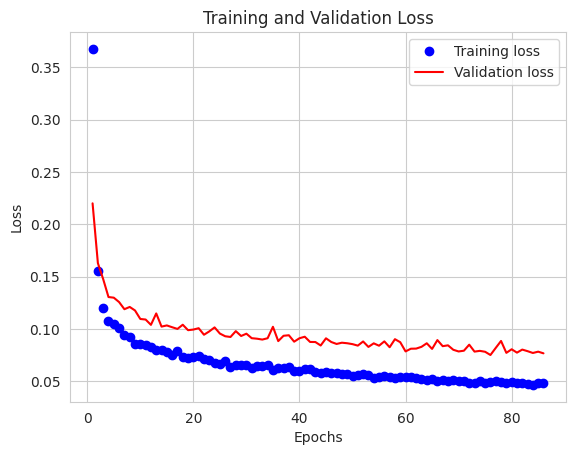

In [19]:
# Solución aquí
# Obtener la pérdida y la precisión del entrenamiento y la evaluación
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida del entrenamiento vs la pérdida de evaluación
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Realiza una visualización de los resultados del entrenamiento y las predicciones de tu modelo RNN a futuro. Es decir, visualizar la secuencia 'ip' y 'sentiment' de test y compararla con la predicción del modelo.</p>
</div>

1/1 [==============================] - 0s 205ms/step


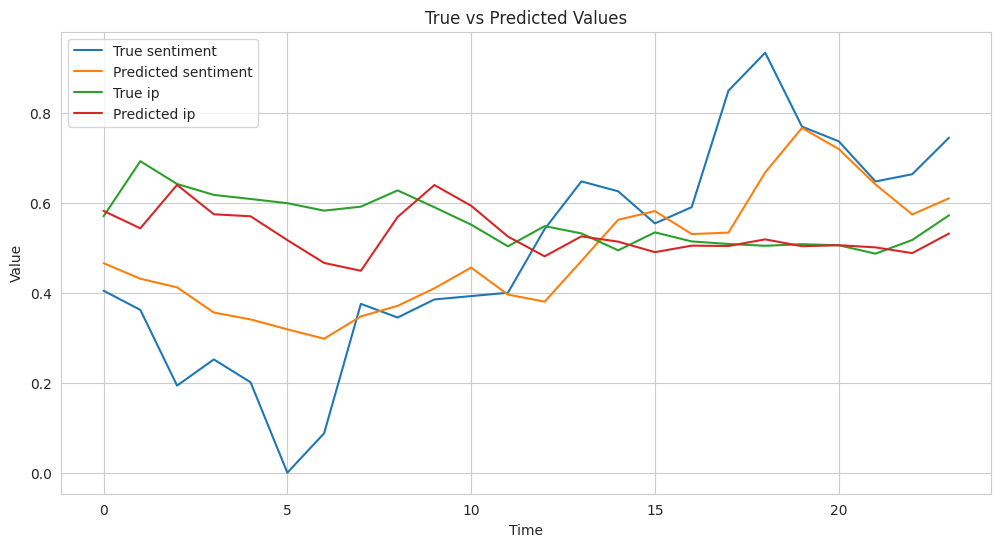

In [20]:
# Código
# Realizar predicciones del modelo en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones y los datos originales de prueba a su escala original si es necesario

# Visualizar las series temporales originales y las predicciones del modelo
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(predictions[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(predictions[:, 1], label='Predicted ip')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 2.2. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo utilizando la red GRU en Keras. Sigue los pasos:</p>
  <ul>
    <li>Define el modelo utilizando la clase <code>Sequential</code>. Incorpora una capa <code>GRU</code> con el número de unidades especificado, aplicando un dropout de 0.1 tanto en las entradas como en las conexiones recurrentes para regularizar el modelo. Asegúrate de que la capa GRU no devuelva secuencias, lo cual es adecuado para conectar directamente a capas densas posteriores.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para establecer el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos con un valor de 2.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa GRU (<code>gru_units=16</code>) y número de unidades en la capa densa (<code>dense_units=8</code>).</li>
    <li>Agrega una capa densa (<code>Dense</code>) con <code>dense_units</code> unidades, similar a la estructura del modelo RNN.</li>
    <li>Finaliza la arquitectura del modelo con una capa de salida (<code>Dense</code>) que tenga un tamaño igual al <code>output_size</code>.</li>
    <li>Muestra un resumen del modelo con el método <code>summary()</code> para verificar la configuración de la arquitectura.</li>
    <li>Compila el modelo utilizando el optimizador 'RMSProp' y la función de pérdida 'mae'.</li>
  </ul>
</div>

In [21]:
K.clear_session()
# Solución
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Número de características de entrada y tamaño de salida
n_features = 2
output_size = 2

# Hiperparámetros del modelo
gru_units = 16
dense_units = 8

# Definir el modelo utilizando la clase Sequential
model_gru = Sequential()

# Capa GRU
model_gru.add(GRU(units=gru_units, input_shape=(None, n_features), dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dropout(0.1))

# Capa densa
model_gru.add(Dense(units=dense_units, activation='relu'))

# Capa de salida
model_gru.add(Dense(units=output_size))

# Mostrar un resumen del modelo
model_gru.summary()

# Compilar el modelo
model_gru.compile(optimizer='RMSProp', loss='mae')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                960       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1114 (4.35 KB)
Trainable params: 1114 (4.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo GRU, visualiza las curvas de entrenamiento vs. evaluación y finalmente visualiza la predicción a futuro tal y como se ha hecho anteriormente.</p>
</div>

Epoch 1/100
21/25 [========================>.....] - ETA: 0s - loss: 0.2190
Epoch 1: val_loss did not improve from 0.07504
25/25 [==============================] - 3s 24ms/step - loss: 0.2029 - val_loss: 0.1505
Epoch 2/100
23/25 [==========================>...] - ETA: 0s - loss: 0.1041
Epoch 2: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 6ms/step - loss: 0.1057 - val_loss: 0.1487
Epoch 3/100
21/25 [========================>.....] - ETA: 0s - loss: 0.1020
Epoch 3: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 8ms/step - loss: 0.1011 - val_loss: 0.1393
Epoch 4/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0917
Epoch 4: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 8ms/step - loss: 0.0912 - val_loss: 0.1276
Epoch 5/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0937
Epoch 5: val_loss did not improve from 0.07504
25/25 [=============================

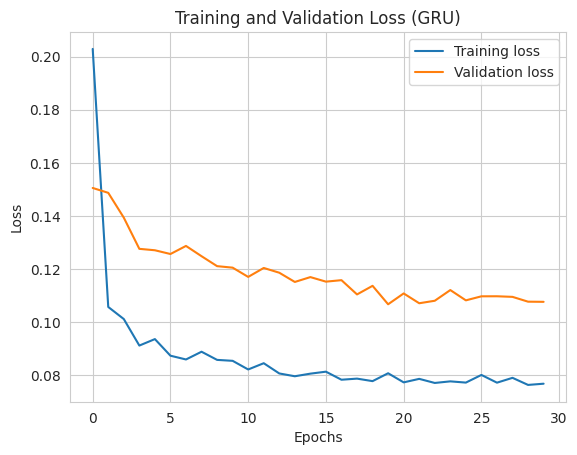

1/1 [==============================] - 0s 287ms/step


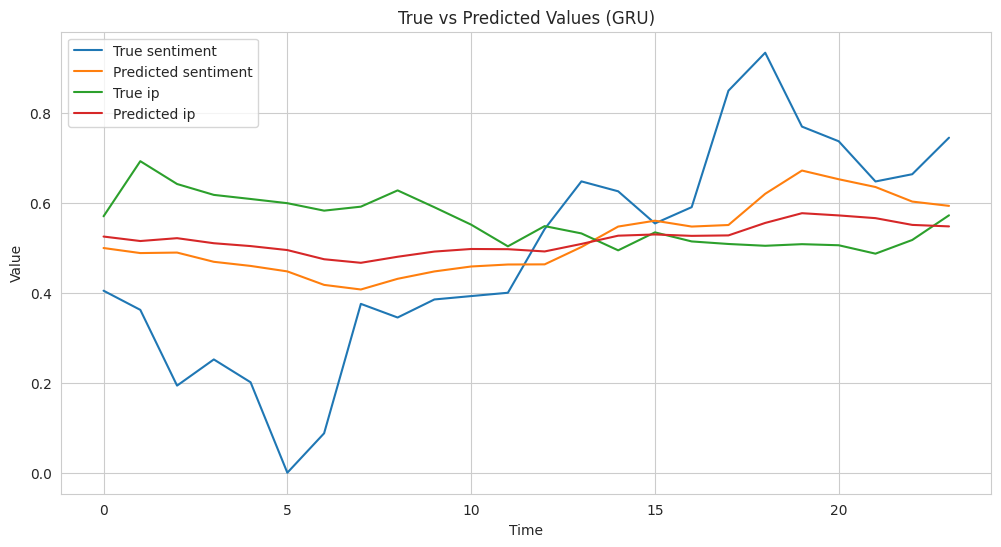

In [22]:
# Solución
# Entrenar el modelo GRU
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), shuffle=False, callbacks=[checkpoint, early_stopping])

# Visualizar las curvas de entrenamiento vs. evaluación
plt.plot(history_gru.history['loss'], label='Training loss')
plt.plot(history_gru.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Realizar predicciones del modelo GRU en el conjunto de prueba
predictions_gru = model_gru.predict(X_test)

# Visualizar las series temporales originales y las predicciones del modelo GRU
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(predictions_gru[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(predictions_gru[:, 1], label='Predicted ip')
plt.title('True vs Predicted Values (GRU)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## 2.3. LSTM

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Define un modelo utilizando la capa LSTM en Keras. Esta arquitectura es adecuada para aprender dependencias de largo plazo en series temporales. Sigue los pasos:</p>
  <ul>
    <li>Utiliza la clase <code>Sequential</code> para definir el modelo. Añade una capa <code>LSTM</code> con el número de unidades especificado, aplicando un dropout del 10% tanto en las entradas como en las conexiones recurrentes para ayudar a prevenir el sobreajuste. Asegúrate de que la capa LSTM esté configurada para no devolver secuencias, lo cual facilita la conexión directa con capas densas posteriores.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para indicar el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos fijados en 2 para este ejercicio.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa LSTM (<code>lstm_units=12</code>) y número de unidades en la capa densa (<code>dense_units=6</code>).</li>
    <li>Integra una capa densa (<code>Dense</code>) con <code>dense_units</code> unidades. Esta capa servirá como capa de conexión antes de la salida del modelo.</li>
    <li>Concluye la arquitectura del modelo con una capa de salida (<code>Dense</code>) que tenga un tamaño igual al <code>output_size</code>.</li>
    <li>Muestra un resumen del modelo con el método <code>summary()</code> para confirmar la configuración de la arquitectura.</li>
    <li>Compila el modelo utilizando 'RMSProp' como optimizador y 'mae'.</li>
  </ul>
</div>

In [23]:
K.clear_session()
# Solución
from keras.layers import LSTM

# Número de características de entrada y tamaño de salida
n_features = 2
output_size = 2

# Hiperparámetros del modelo
lstm_units = 12
dense_units = 6

# Definir el modelo utilizando la clase Sequential
model_lstm = Sequential()

# Capa LSTM
model_lstm.add(LSTM(units=lstm_units, input_shape=(None, n_features), dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dropout(0.1))

# Capa densa
model_lstm.add(Dense(units=dense_units, activation='relu'))

# Capa de salida
model_lstm.add(Dense(units=output_size))

# Mostrar un resumen del modelo
model_lstm.summary()

# Compilar el modelo
model_lstm.compile(optimizer='RMSProp', loss='mae')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12)                720       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 6)                 78        
                                                                 
 dense_1 (Dense)             (None, 2)                 14        
                                                                 
Total params: 812 (3.17 KB)
Trainable params: 812 (3.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Entrena el modelo LSTM, visualiza las curvas de entrenamiento vs. evaluación y finalmente visualiza la predicción a futuro tal y cómo se ha hecho anteriormente.</p>
</div>

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 0.4751
Epoch 1: val_loss did not improve from 0.07504
25/25 [==============================] - 4s 34ms/step - loss: 0.4733 - val_loss: 0.3014
Epoch 2/100
23/25 [==========================>...] - ETA: 0s - loss: 0.2179
Epoch 2: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 9ms/step - loss: 0.2129 - val_loss: 0.1272
Epoch 3/100
21/25 [========================>.....] - ETA: 0s - loss: 0.1100
Epoch 3: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 7ms/step - loss: 0.1073 - val_loss: 0.1301
Epoch 4/100
19/25 [=====================>........] - ETA: 0s - loss: 0.1094
Epoch 4: val_loss did not improve from 0.07504
25/25 [==============================] - 0s 8ms/step - loss: 0.1064 - val_loss: 0.1263
Epoch 5/100
20/25 [=======================>......] - ETA: 0s - loss: 0.1006
Epoch 5: val_loss did not improve from 0.07504
25/25 [=============================

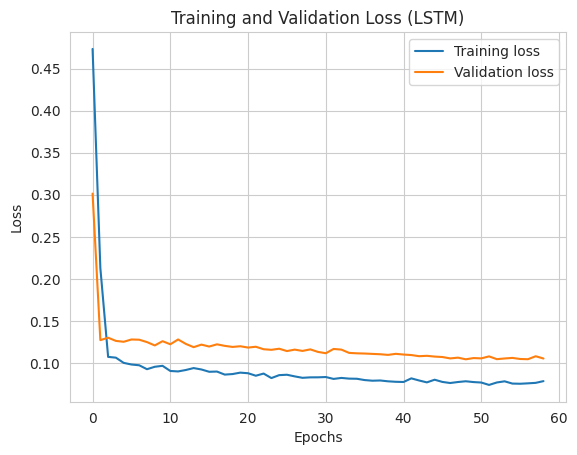

1/1 [==============================] - 0s 248ms/step


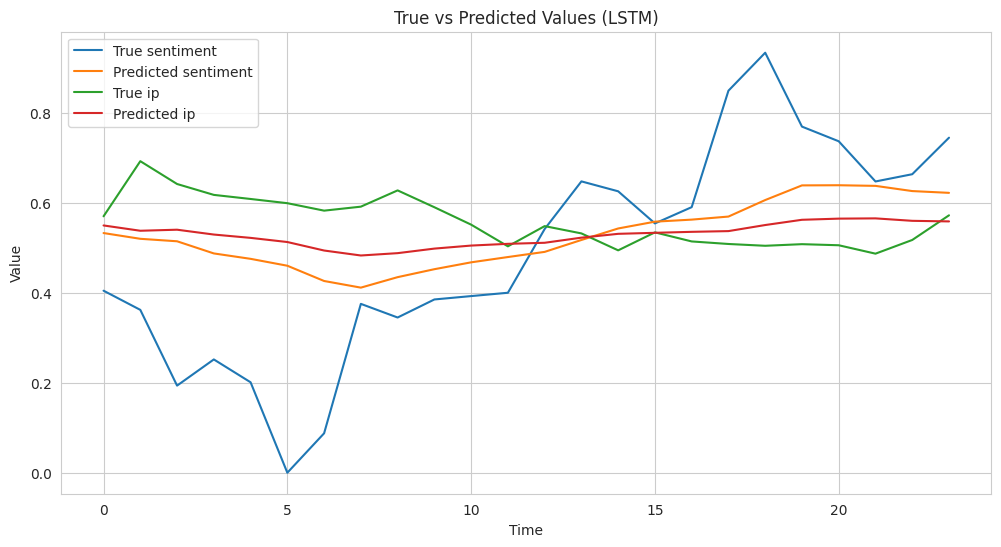

In [25]:
# Solución
# Entrenar el modelo LSTM
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), shuffle=False, callbacks=[checkpoint, early_stopping])

# Visualizar las curvas de entrenamiento vs. evaluación
plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Realizar predicciones del modelo LSTM en el conjunto de prueba
predictions_lstm = model_lstm.predict(X_test)

# Visualizar las series temporales originales y las predicciones del modelo LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(predictions_lstm[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(predictions_lstm[:, 1], label='Predicted ip')
plt.title('True vs Predicted Values (LSTM)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## 2.4. LSTM Mejorada

En este apartado vamos a tratar de mejorar la capacidad de la red añadiéndo algunas mejoras que aumentan la capacidad de representación de la red neuronal.

Una de las mejoras va a consistir en utilizar otro tipo de función de activación periódica basada en la fórmula del seno lo que la hace particularmente adecuada para aprender representaciones de datos que son intrínsecamente periódicos o cíclicos.

La función de activación SIREN (SInusoidal REpresentation Networks) es un tipo de función de activación introducida por investigadores para mejorar la capacidad de las redes neuronales, especialmente en tareas que involucran la modelación de fenómenos periódicos o el manejo de derivadas de alto orden, como se ve en tareas de procesamiento de señales, imágenes, y audio. La función SIREN utiliza senos como funciones de activación en lugar de las tradicionales ReLU, sigmoides, o tanh. La fórmula general de una función de activación SIREN es
ϕ(x)=sin(wx+b), donde
w y
b son parámetros que se aprenden durante el entrenamiento de la red.

Esta capa de activación ofrece derivadas suaves y continuas, lo que es beneficioso para modelar relaciones complejas en los datos, incluyendo aquellas donde las derivadas de alto orden son relevantes (como en la modelación física).

Para más información: [https://arxiv.org/abs/2006.09661](https://arxiv.org/abs/2006.09661)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Expande la arquitectura LSTM estándar incorporando una función de activación Sinusoidal (SIREN) para explorar su impacto en el aprendizaje de dependencias temporales complejas. Sigue los pasos para configurar y definir este modelo en Keras:</p>
  <ul>
    <li>Define una función <code>siren_activation</code> que aplique la activación SIREN, utilizando el seno de la entrada multiplicada por un parámetro de frecuencia <code>w0</code>. Este tipo de activación será particularmente útil para modelar patrones periódicos y no linealidades complejas en los datos.</li>
    <li>Configura las variables <code>n_features</code> y <code>output_size</code> para representar el número de características de entrada y el tamaño de salida del modelo, respectivamente, ambos establecidos en 2.</li>
    <li>Establece los hiperparámetros del modelo: número de unidades en la capa LSTM (<code>lstm_units=24</code>), número de unidades en la capa densa (<code>dense_units=12</code>), y tamaño de la ventana de entrada (<code>window_size=24</code>).</li>
    <li>Utiliza la clase <code>Sequential</code> para definir el modelo. Añade una capa <code>LSTM</code> configurada con los parámetros especificados y asegúrate de que no devuelva secuencias para facilitar la conexión directa a la capa densa posterior.</li>
    <li>Incorpora la activación SIREN inmediatamente después de la capa LSTM utilizando la capa <code>Lambda</code>, que permite aplicar funciones personalizadas como parte de la arquitectura del modelo.</li>
    <li>Completa la arquitectura del modelo con una capa densa y una capa de salida, como en modelos LSTM estándar.</li>
    <li>Compila el modelo con 'RMSProp' como optimizador y 'mae'.</li>
    <li>Muestra un resumen del modelo con <code>summary()</code> para confirmar la estructura y configuración de la arquitectura.</li>
    <li>Entrena el modelo como anteriormente.</li>
    <li>Muestra las predicciones visualizando las series temporales.</li>
  </ul>
</div>

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                2592      
                                                                 
 lambda (Lambda)             (None, 24)                0         
                                                                 
 dense (Dense)               (None, 12)                300       
                                                                 
 dense_1 (Dense)             (None, 2)                 26        
                                                                 
Total params: 2918 (11.40 KB)
Trainable params: 2918 (11.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
16/25 [==================>...........] - ETA: 0s - loss: 0.5651  
Epoch 1: val_loss did not improve from 0.07504
25/25 [======================

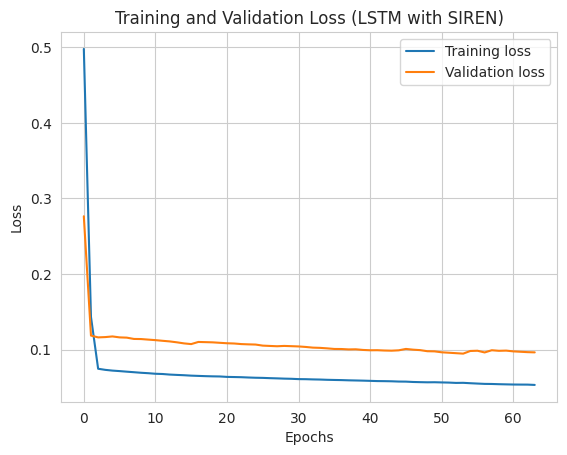

1/1 [==============================] - 0s 424ms/step


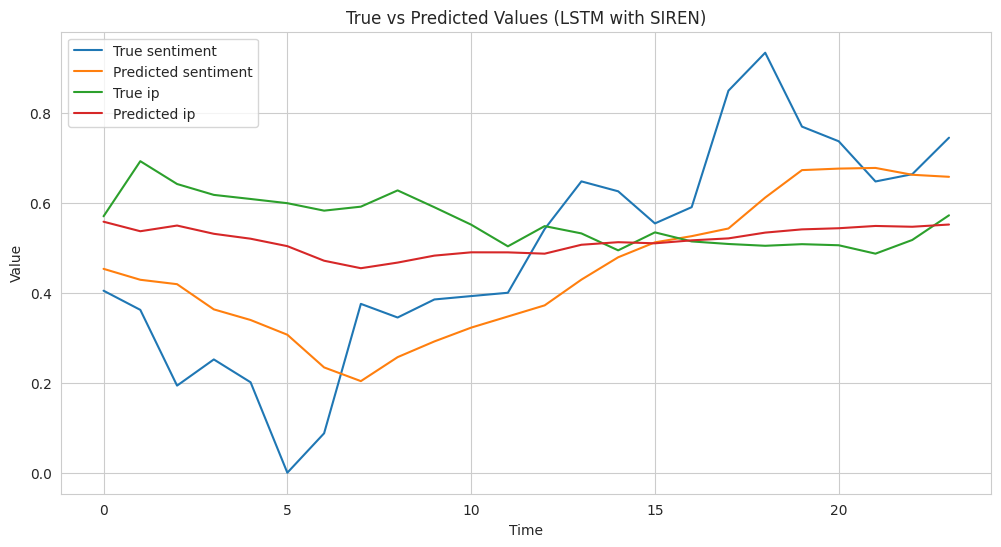

In [28]:
K.clear_session()
# Solución
from keras.layers import Lambda
def siren_activation(x):
    import tensorflow as tf
    w0 = 1.0
    return tf.sin(w0 * x) # Definir la función SENO

# Configurar variables
n_features = 2
output_size = 2
lstm_units = 24
dense_units = 12
window_size = 6

# Definir el modelo LSTM mejorado con activación SIREN
model_lstm_siren = Sequential([
    LSTM(units=lstm_units, input_shape=(window_size, n_features), return_sequences=False),
    Lambda(siren_activation),
    Dense(dense_units, activation='relu'),
    Dense(output_size)
])

# Compilar el modelo
model_lstm_siren.compile(optimizer='RMSProp', loss='mae')

# Mostrar resumen del modelo
model_lstm_siren.summary()

# Entrenar el modelo
history_lstm_siren = model_lstm_siren.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), shuffle=False, callbacks=[checkpoint, early_stopping])

# Visualizar las curvas de entrenamiento vs. evaluación
plt.plot(history_lstm_siren.history['loss'], label='Training loss')
plt.plot(history_lstm_siren.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss (LSTM with SIREN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Realizar predicciones del modelo LSTM mejorado en el conjunto de prueba
predictions_lstm_siren = model_lstm_siren.predict(X_test)

# Visualizar las series temporales originales y las predicciones del modelo LSTM mejorado
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(predictions_lstm_siren[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(predictions_lstm_siren[:, 1], label='Predicted ip')
plt.title('True vs Predicted Values (LSTM with SIREN)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# 3. Data Evaluation

Hasta ahora hemos aprendido a crear un modelo de red neuronal de tipo recurrente para datos que tienen un factor temporal y debe de ser tomado en cuenta. Sin embargo, en vuestro día a día laboral, necesitaréis no solo crear un buen modelo, sino también ser capaces de justificar por qué habéis diseñado y entrenado un buen modelo. Para ello, se van a proponer una serie de ejercicios que nos van a guiar en esta justificación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Crea una tabla que evalue y compare el rendimiento de tus modelos en los datos de test. ¿Crees que la precisión podría mejorar? Discute si existe la necesidad de reentrenar tu modelo, considerando nuevas estrategias para mejorar su rendimiento.</p>
</div>

In [45]:
K.clear_session()
# Código aquí
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#RNN
# Calculamos mae
mae_rnn = mean_absolute_error(y_test, predictions)
# Calculamos MSE
mse_rnn = mean_squared_error(y_test, predictions)
# Calculamos R^2
r2_rnn = r2_score(y_test, predictions)

#GRU
# Calculamos mae
mae_GRU = mean_absolute_error(y_test, predictions_gru)
# Calculamos MSE
mse_GRU = mean_squared_error(y_test, predictions_gru)
# Calculamos R^2
r2_GRU = r2_score(y_test, predictions_gru)

#lstm
# Calculamos mae
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
# Calculamos MSE
mse_lstm = mean_squared_error(y_test, predictions_lstm)
# Calculamos R^2
r2_lstm = r2_score(y_test, predictions_lstm)

#lstm_siren
# Calculamos mae
mae_lstm_siren = mean_absolute_error(y_test, predictions_lstm_siren)
# Calculamos MSE
mse_lstm_siren = mean_squared_error(y_test, predictions_lstm_siren)
# Calculamos R^2
r2_lstm_siren = r2_score(y_test, predictions_lstm_siren)

# Definir los errores obtenidos de cada modelo
errors = {
    "Modelo": ["RNN", "GRU", "LSTM", "LSTM Mejorada"],
    "MAE": [mae_rnn, mae_GRU, mae_lstm, mae_lstm_siren],
    "MSE": [mse_rnn, mse_GRU, mse_lstm, mse_lstm_siren],
    "R^2": [r2_rnn, r2_GRU, r2_lstm, r2_lstm_siren]
}

# Crear DataFrame
df_errors = pd.DataFrame(errors)

# Mostrar la tabla
df_errors

,Modelo,MAE,MSE,R^2
0,RNN,0.075041,0.012206,0.199907
1,GRU,0.106709,0.020655,-0.529689
2,LSTM,0.104427,0.021081,-0.258488
3,LSTM Mejorada,0.094662,0.015116,-0.262519


Basándonos en los valores de los errores MAE, MSE y R^2 de los modelos, se tienen los siguientes hallazgos:

* El modelo RNN tiene el menor MAE y MSE, lo que indica que tiene el mejor rendimiento en términos de precisión de predicción en comparación con los otros modelos.
* Sin embargo, el R^2 del modelo RNN es bastante bajo, lo que sugiere que el modelo explica solo una pequeña parte de la variabilidad de los datos de prueba.
* Los modelos GRU, LSTM y LSTM Mejorada tienen valores de MAE, MSE y R^2 similares, pero en general, tienen un rendimiento inferior al modelo RNN.
* Todos los modelos tienen un R^2 negativo, lo que indica que el modelo no se ajusta bien a los datos de prueba y no es capaz de explicar la variabilidad en los datos.

Dado que ninguno de los modelos muestra un rendimiento satisfactorio en términos de R^2 y los modelos GRU, LSTM y LSTM Mejorada tienen un rendimiento ligeramente inferior al modelo RNN en términos de MAE y MSE, es posible que sea necesario reconsiderar la arquitectura del modelo.

## 3.1. Hiperparametrización

Ahora que has identificado la necesidad de mejorar tu modelo, procede a reentrenarlo utilizando el conjunto de datos de prueba. Además, emplea una herramienta de hiperparametrización como Optuna para ajustar los hiperparámetros del modelo, incluyendo el número de neuronas, tipos de activación de las capas y tasas de dropout.

Instala optuna con "pip install optuna"

In [30]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.4 MB/s eta 0:00:00



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Realiza una optimización de hiperparámetros utilizando Optuna para el modelo LSTM del ejercicio 2.4. que incorpora una opción de activación personalizada, y entrena el modelo con el conjunto de hiperparámetros óptimos. Finalmente, guarda el modelo entrenado. Sigue estos pasos:</p>
  <ul>
    <li>Define una función <code>create_model</code> que construye el modelo LSTM visto anteriormente pero que hiperparametrizaremos. Dentro de esta función, utiliza Optuna para sugerir valores para los siguientes hiperparámetros: número de unidades en la capa LSTM, número de unidades en la capa densa, tasa de dropout, y el tipo de función de activación (con opciones 'relu' y 'siren').</li>
    <li>Si se elige 'siren' como función de activación, sugiere un valor para el parámetro de frecuencia <code>w0</code> y utiliza la activación SIREN personalizada. De lo contrario, utiliza 'relu'.</li>
    <li>Configura y define el modelo LSTM basado en los hiperparámetros elegidos. Añade una capa LSTM seguida de la activación elegida, una capa densa, y finalmente una capa de salida.</li>
    <li>Define la función de pérdida MAE para la optimización con Optuna que compila y entrena el modelo definido.</li>
    <li>Lanza Optuna para crear un estudio y ejecuta una búsqueda de hiperparámetros limitada a un número definido de pruebas.</li>
    <li>Después de completar la optimización, imprime el número de pruebas completadas y los hiperparámetros del mejor modelo encontrado.</li>
  </ul>
</div>

In [35]:
# Código

from keras.models import Sequential
from keras.layers import LSTM, Lambda, Dense
from keras.optimizers import RMSprop
from keras.losses import MeanAbsoluteError
import numpy as np

# Definir función para crear el modelo LSTM con hiperparámetros variables
def create_model(trial):
    lstm_units = trial.suggest_int('lstm_units', 16, 64)
    dense_units = trial.suggest_int('dense_units', 8, 32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    model = Sequential([
        LSTM(units=lstm_units, input_shape=(window_size, n_features), return_sequences=False),
        Lambda(siren_activation),
        Dense(dense_units, activation='relu'),
        Dense(output_size)
    ])
    model.compile(optimizer=RMSprop(), loss=MeanAbsoluteError())
    return model

# Definir función de pérdida para la optimización con Optuna
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=10, batch_size=20, verbose=0)
    score = model.evaluate(X_test, y_test)
    return score

# Crear un estudio Optuna y ejecutar una búsqueda de hiperparámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Imprimir el número de pruebas completadas y los hiperparámetros del mejor modelo encontrado
print('Número de pruebas completadas:', len(study.trials))
print('Mejores hiperparámetros:', study.best_params)

[I 2024-04-30 11:20:06,175] A new study created in memory with name: no-name-3b999975-b78f-4ae3-ae9f-eba55daef219


1/1 [==============================] - 1s 531ms/step - loss: 0.0923


[I 2024-04-30 11:20:09,962] Trial 0 finished with value: 0.09232199192047119 and parameters: {'lstm_units': 44, 'dense_units': 32, 'dropout_rate': 0.33514772242112756, 'activation_type': 'relu'}. Best is trial 0 with value: 0.09232199192047119.


1/1 [==============================] - 0s 441ms/step - loss: 0.0921


[I 2024-04-30 11:20:14,463] Trial 1 finished with value: 0.09212404489517212 and parameters: {'lstm_units': 32, 'dense_units': 31, 'dropout_rate': 0.4767861652449846, 'activation_type': 'relu'}. Best is trial 1 with value: 0.09212404489517212.


1/1 [==============================] - 0s 460ms/step - loss: 0.0918


[I 2024-04-30 11:20:18,514] Trial 2 finished with value: 0.09179080277681351 and parameters: {'lstm_units': 31, 'dense_units': 12, 'dropout_rate': 0.34946064413304656, 'activation_type': 'relu'}. Best is trial 2 with value: 0.09179080277681351.


1/1 [==============================] - 0s 458ms/step - loss: 0.1065


[I 2024-04-30 11:20:22,153] Trial 3 finished with value: 0.1064513549208641 and parameters: {'lstm_units': 52, 'dense_units': 14, 'dropout_rate': 0.36439295014617235, 'activation_type': 'siren', 'w0': 0.6878570422595653}. Best is trial 2 with value: 0.09179080277681351.


1/1 [==============================] - 0s 477ms/step - loss: 0.0948


[I 2024-04-30 11:20:27,160] Trial 4 finished with value: 0.09480325132608414 and parameters: {'lstm_units': 25, 'dense_units': 18, 'dropout_rate': 0.40083252684619497, 'activation_type': 'siren', 'w0': 0.498947431290396}. Best is trial 2 with value: 0.09179080277681351.


1/1 [==============================] - 0s 444ms/step - loss: 0.0902


[I 2024-04-30 11:20:30,723] Trial 5 finished with value: 0.09024106711149216 and parameters: {'lstm_units': 59, 'dense_units': 19, 'dropout_rate': 0.27166562110601555, 'activation_type': 'siren', 'w0': 0.2013603031409644}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 1s 531ms/step - loss: 0.0973


[I 2024-04-30 11:20:34,388] Trial 6 finished with value: 0.09733664244413376 and parameters: {'lstm_units': 34, 'dense_units': 29, 'dropout_rate': 0.49836433183504225, 'activation_type': 'relu'}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 461ms/step - loss: 0.1070


[I 2024-04-30 11:20:40,587] Trial 7 finished with value: 0.10697325319051743 and parameters: {'lstm_units': 38, 'dense_units': 8, 'dropout_rate': 0.2131232423974895, 'activation_type': 'siren', 'w0': 0.6985178073666028}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 445ms/step - loss: 0.1054


[I 2024-04-30 11:20:44,147] Trial 8 finished with value: 0.10539577156305313 and parameters: {'lstm_units': 22, 'dense_units': 16, 'dropout_rate': 0.14129518286566536, 'activation_type': 'siren', 'w0': 0.31159591925939745}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 483ms/step - loss: 0.0959


[I 2024-04-30 11:20:47,814] Trial 9 finished with value: 0.09586194902658463 and parameters: {'lstm_units': 37, 'dense_units': 19, 'dropout_rate': 0.25256590973987625, 'activation_type': 'siren', 'w0': 0.12075248980992938}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 456ms/step - loss: 0.0996


[I 2024-04-30 11:20:52,223] Trial 10 finished with value: 0.09958169609308243 and parameters: {'lstm_units': 64, 'dense_units': 24, 'dropout_rate': 0.1541725738046478, 'activation_type': 'siren', 'w0': 0.11349752929780975}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 489ms/step - loss: 0.1009


[I 2024-04-30 11:20:56,755] Trial 11 finished with value: 0.10093554109334946 and parameters: {'lstm_units': 58, 'dense_units': 11, 'dropout_rate': 0.2830047435846914, 'activation_type': 'relu'}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 451ms/step - loss: 0.0914


[I 2024-04-30 11:21:00,358] Trial 12 finished with value: 0.09143992513418198 and parameters: {'lstm_units': 49, 'dense_units': 24, 'dropout_rate': 0.4087306238508502, 'activation_type': 'relu'}. Best is trial 5 with value: 0.09024106711149216.


1/1 [==============================] - 0s 464ms/step - loss: 0.0889


[I 2024-04-30 11:21:04,707] Trial 13 finished with value: 0.08894465118646622 and parameters: {'lstm_units': 47, 'dense_units': 24, 'dropout_rate': 0.2168227640189247, 'activation_type': 'relu'}. Best is trial 13 with value: 0.08894465118646622.


1/1 [==============================] - 0s 453ms/step - loss: 0.1040


[I 2024-04-30 11:21:08,338] Trial 14 finished with value: 0.10396280139684677 and parameters: {'lstm_units': 55, 'dense_units': 23, 'dropout_rate': 0.20780481976158952, 'activation_type': 'siren', 'w0': 0.9771376177209714}. Best is trial 13 with value: 0.08894465118646622.


1/1 [==============================] - 0s 463ms/step - loss: 0.0982


[I 2024-04-30 11:21:12,000] Trial 15 finished with value: 0.09820546954870224 and parameters: {'lstm_units': 46, 'dense_units': 27, 'dropout_rate': 0.21192396270823352, 'activation_type': 'relu'}. Best is trial 13 with value: 0.08894465118646622.


1/1 [==============================] - 1s 920ms/step - loss: 0.0863


[I 2024-04-30 11:21:16,952] Trial 16 finished with value: 0.0863056555390358 and parameters: {'lstm_units': 63, 'dense_units': 22, 'dropout_rate': 0.27289911693215557, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 1s 741ms/step - loss: 0.0903


[I 2024-04-30 11:21:22,729] Trial 17 finished with value: 0.09032886475324631 and parameters: {'lstm_units': 17, 'dense_units': 23, 'dropout_rate': 0.11778922246111556, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 498ms/step - loss: 0.1066


[I 2024-04-30 11:21:28,895] Trial 18 finished with value: 0.10663535445928574 and parameters: {'lstm_units': 64, 'dense_units': 28, 'dropout_rate': 0.16846047829138405, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 446ms/step - loss: 0.0973


[I 2024-04-30 11:21:32,477] Trial 19 finished with value: 0.09732494503259659 and parameters: {'lstm_units': 43, 'dense_units': 21, 'dropout_rate': 0.31095732871816634, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 457ms/step - loss: 0.0919


[I 2024-04-30 11:21:36,163] Trial 20 finished with value: 0.09188833087682724 and parameters: {'lstm_units': 51, 'dense_units': 26, 'dropout_rate': 0.24096978984193457, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 443ms/step - loss: 0.0950


[I 2024-04-30 11:21:42,606] Trial 21 finished with value: 0.09503235667943954 and parameters: {'lstm_units': 59, 'dense_units': 21, 'dropout_rate': 0.2777074946344408, 'activation_type': 'siren', 'w0': 0.37678686311927967}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 460ms/step - loss: 0.0996


[I 2024-04-30 11:21:46,227] Trial 22 finished with value: 0.09960434585809708 and parameters: {'lstm_units': 58, 'dense_units': 17, 'dropout_rate': 0.18484307746565015, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 490ms/step - loss: 0.0933


[I 2024-04-30 11:21:49,990] Trial 23 finished with value: 0.09332504868507385 and parameters: {'lstm_units': 61, 'dense_units': 20, 'dropout_rate': 0.2632913207602579, 'activation_type': 'siren', 'w0': 0.34388492524150244}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 456ms/step - loss: 0.1003


[I 2024-04-30 11:21:54,493] Trial 24 finished with value: 0.1003231629729271 and parameters: {'lstm_units': 54, 'dense_units': 25, 'dropout_rate': 0.31732120163030253, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 1s 631ms/step - loss: 0.0937


[I 2024-04-30 11:21:58,318] Trial 25 finished with value: 0.09365430474281311 and parameters: {'lstm_units': 48, 'dense_units': 22, 'dropout_rate': 0.23746572253283998, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 1s 592ms/step - loss: 0.1055


[I 2024-04-30 11:22:03,853] Trial 26 finished with value: 0.10546157509088516 and parameters: {'lstm_units': 55, 'dense_units': 16, 'dropout_rate': 0.2924289530912139, 'activation_type': 'siren', 'w0': 0.9882783098035988}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 452ms/step - loss: 0.0974


[I 2024-04-30 11:22:08,130] Trial 27 finished with value: 0.09741267561912537 and parameters: {'lstm_units': 61, 'dense_units': 19, 'dropout_rate': 0.1955094965041084, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 468ms/step - loss: 0.0967


[I 2024-04-30 11:22:11,996] Trial 28 finished with value: 0.09672081470489502 and parameters: {'lstm_units': 41, 'dense_units': 29, 'dropout_rate': 0.3799434791161179, 'activation_type': 'siren', 'w0': 0.2093092550446628}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 442ms/step - loss: 0.0921


[I 2024-04-30 11:22:15,583] Trial 29 finished with value: 0.0920606255531311 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.3272147009023736, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 450ms/step - loss: 0.1060


[I 2024-04-30 11:22:19,936] Trial 30 finished with value: 0.10603306442499161 and parameters: {'lstm_units': 46, 'dense_units': 15, 'dropout_rate': 0.2330859482344168, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 462ms/step - loss: 0.0929


[I 2024-04-30 11:22:23,524] Trial 31 finished with value: 0.09291237592697144 and parameters: {'lstm_units': 19, 'dense_units': 22, 'dropout_rate': 0.11417859929805861, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 461ms/step - loss: 0.0957


[I 2024-04-30 11:22:27,204] Trial 32 finished with value: 0.0956685021519661 and parameters: {'lstm_units': 27, 'dense_units': 25, 'dropout_rate': 0.12093412343043919, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 457ms/step - loss: 0.0916


[I 2024-04-30 11:22:31,724] Trial 33 finished with value: 0.09156728535890579 and parameters: {'lstm_units': 29, 'dense_units': 23, 'dropout_rate': 0.17287368278138499, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 456ms/step - loss: 0.1067


[I 2024-04-30 11:22:35,310] Trial 34 finished with value: 0.10671214014291763 and parameters: {'lstm_units': 34, 'dense_units': 20, 'dropout_rate': 0.261720550049563, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 471ms/step - loss: 0.1147


[I 2024-04-30 11:22:40,147] Trial 35 finished with value: 0.11466124653816223 and parameters: {'lstm_units': 17, 'dense_units': 26, 'dropout_rate': 0.3467126767318219, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 464ms/step - loss: 0.0907


[I 2024-04-30 11:22:44,725] Trial 36 finished with value: 0.09069786220788956 and parameters: {'lstm_units': 52, 'dense_units': 18, 'dropout_rate': 0.10210219594340708, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 459ms/step - loss: 0.1111


[I 2024-04-30 11:22:48,385] Trial 37 finished with value: 0.11106959730386734 and parameters: {'lstm_units': 61, 'dense_units': 22, 'dropout_rate': 0.4548105993032462, 'activation_type': 'siren', 'w0': 0.6136197577576732}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 462ms/step - loss: 0.1034


[I 2024-04-30 11:22:52,042] Trial 38 finished with value: 0.10343875735998154 and parameters: {'lstm_units': 56, 'dense_units': 30, 'dropout_rate': 0.29490096524858495, 'activation_type': 'relu'}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 476ms/step - loss: 0.0895


[I 2024-04-30 11:22:57,584] Trial 39 finished with value: 0.08946671336889267 and parameters: {'lstm_units': 23, 'dense_units': 18, 'dropout_rate': 0.13370617250989847, 'activation_type': 'siren', 'w0': 0.8064518022276512}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 453ms/step - loss: 0.1146


[I 2024-04-30 11:23:01,156] Trial 40 finished with value: 0.11457701772451401 and parameters: {'lstm_units': 24, 'dense_units': 13, 'dropout_rate': 0.14685157974913168, 'activation_type': 'siren', 'w0': 0.8309232216196889}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 485ms/step - loss: 0.0980


[I 2024-04-30 11:23:04,809] Trial 41 finished with value: 0.09797078371047974 and parameters: {'lstm_units': 21, 'dense_units': 18, 'dropout_rate': 0.14310762633994736, 'activation_type': 'siren', 'w0': 0.8263949238644999}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 451ms/step - loss: 0.1047


[I 2024-04-30 11:23:09,286] Trial 42 finished with value: 0.10474935919046402 and parameters: {'lstm_units': 21, 'dense_units': 19, 'dropout_rate': 0.12897720868262755, 'activation_type': 'siren', 'w0': 0.4827631894048155}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 461ms/step - loss: 0.0897


[I 2024-04-30 11:23:12,871] Trial 43 finished with value: 0.08970653265714645 and parameters: {'lstm_units': 16, 'dense_units': 21, 'dropout_rate': 0.22522427236057485, 'activation_type': 'siren', 'w0': 0.8616323908124199}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 470ms/step - loss: 0.0923


[I 2024-04-30 11:23:16,554] Trial 44 finished with value: 0.09231116622686386 and parameters: {'lstm_units': 37, 'dense_units': 17, 'dropout_rate': 0.27167491489931545, 'activation_type': 'siren', 'w0': 0.8209803118868793}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 463ms/step - loss: 0.0961


[I 2024-04-30 11:23:21,851] Trial 45 finished with value: 0.09614241123199463 and parameters: {'lstm_units': 31, 'dense_units': 21, 'dropout_rate': 0.23395817875570124, 'activation_type': 'siren', 'w0': 0.8700820342132168}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 1s 870ms/step - loss: 0.0888


[I 2024-04-30 11:23:27,606] Trial 46 finished with value: 0.0887579694390297 and parameters: {'lstm_units': 25, 'dense_units': 14, 'dropout_rate': 0.2179187650200755, 'activation_type': 'siren', 'w0': 0.7225233461865477}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 1s 681ms/step - loss: 0.0915


[I 2024-04-30 11:23:31,471] Trial 47 finished with value: 0.0914982482790947 and parameters: {'lstm_units': 24, 'dense_units': 12, 'dropout_rate': 0.2141371426043714, 'activation_type': 'siren', 'w0': 0.7345838229316705}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 461ms/step - loss: 0.1028


[I 2024-04-30 11:23:35,635] Trial 48 finished with value: 0.1028452143073082 and parameters: {'lstm_units': 16, 'dense_units': 8, 'dropout_rate': 0.19186920165577648, 'activation_type': 'siren', 'w0': 0.6137214748811178}. Best is trial 16 with value: 0.0863056555390358.


1/1 [==============================] - 0s 449ms/step - loss: 0.0968


[I 2024-04-30 11:23:39,232] Trial 49 finished with value: 0.09677726030349731 and parameters: {'lstm_units': 27, 'dense_units': 14, 'dropout_rate': 0.16720943323384507, 'activation_type': 'siren', 'w0': 0.9042490884162638}. Best is trial 16 with value: 0.0863056555390358.


Número de pruebas completadas: 50
Mejores hiperparámetros: {'lstm_units': 63, 'dense_units': 22, 'dropout_rate': 0.27289911693215557, 'activation_type': 'relu'}


## 3.1.1. Entrenamiento Mejor Modelo de Optuna

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Entrena tu mejor modelo con Optuna:</p>
  <ul>
<li>Crea y entrena un nuevo modelo LSTM utilizando los mejores hiperparámetros identificados. Entrena este modelo en el conjunto de entrenamiento y valida su desempeño utilizando.</li>
    <li>Guarda el modelo entrenado en la ruta especificada y muestra un mensaje confirmando la ubicación del archivo guardado.</li>
      <li>Visualiza las predicciones tal y como se ha hecho anteriormente.</li>
    <li>Añade y compara tu mejor modelo a la tabla anterior para comparar resultados.</li>
        </ul>
</div>

In [36]:
# Código

# Importar las librerías necesarias
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Definir la función para crear el mejor modelo LSTM identificado por Optuna
def create_best_model():
    model = Sequential([
        LSTM(units=63, input_shape=(window_size, n_features), return_sequences=False),
        Lambda(lambda x: x),  # No se necesita ninguna activación especial ya que usamos 'relu' como predeterminado
        Dense(22, activation='relu'),
        Dense(output_size)
    ])
    model.compile(optimizer='RMSprop', loss='mae')
    return model

# Crear el modelo
best_model = create_best_model()

# Definir callbacks para guardar el mejor modelo y detener el entrenamiento si no mejora
checkpoint_path = "/content/results/best_lstm_model.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = best_model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test), callbacks=[model_checkpoint, early_stopping], verbose=1)

# Mostrar mensaje de confirmación de la ubicación del archivo guardado
print("El mejor modelo entrenado ha sido guardado en:", checkpoint_path)




Epoch 1/100
12/25 [=============>................] - ETA: 0s - loss: 0.2133 
Epoch 1: val_loss improved from inf to 0.12093, saving model to /content/results/best_lstm_model.h5
25/25 [==============================] - 3s 27ms/step - loss: 0.1436 - val_loss: 0.1209
Epoch 2/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0704
Epoch 2: val_loss improved from 0.12093 to 0.11269, saving model to /content/results/best_lstm_model.h5
25/25 [==============================] - 0s 8ms/step - loss: 0.0701 - val_loss: 0.1127
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.0680
Epoch 3: val_loss improved from 0.11269 to 0.10735, saving model to /content/results/best_lstm_model.h5
25/25 [==============================] - 0s 7ms/step - loss: 0.0680 - val_loss: 0.1073
Epoch 4/100
13/25 [==============>...............] - ETA: 0s - loss: 0.0632
Epoch 4: val_loss improved from 0.10735 to 0.09610, saving model to /content/results/best_lstm_model.h5
25/25 [==============

1/1 [==============================] - 0s 21ms/step


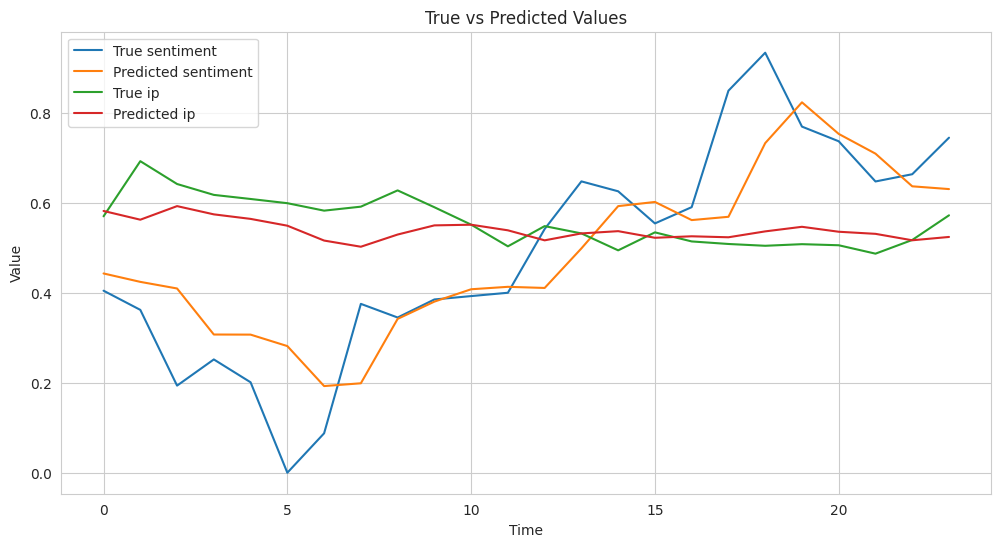

In [39]:
# Visualizar las predicciones

# Realizar predicciones con el mejor modelo
best_predictions = best_model.predict(X_test)

# Visualizar las series temporales originales y las predicciones del modelo
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(best_predictions[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(best_predictions[:, 1], label='Predicted ip')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [46]:
df_errors

,Modelo,MAE,MSE,R^2
0,RNN,0.075041,0.012206,0.199907
1,GRU,0.106709,0.020655,-0.529689
2,LSTM,0.104427,0.021081,-0.258488
3,LSTM Mejorada,0.094662,0.015116,-0.262519


In [47]:
# Crear un diccionario con los errores del modelo
mae_optuna = mean_absolute_error(y_test, best_predictions)
mse_optuna = mean_squared_error(y_test, best_predictions)
r_squared_optuna = r2_score(y_test, best_predictions)
df_errors.loc[4]=['Mejor LSTM con Optuna',mae_optuna,mse_optuna,r_squared_optuna]



In [52]:
df_errors

,Modelo,MAE,MSE,R^2
0,RNN,0.075041,0.012206,0.199907
1,GRU,0.106709,0.020655,-0.529689
2,LSTM,0.104427,0.021081,-0.258488
3,LSTM Mejorada,0.094662,0.015116,-0.262519
4,Mejor LSTM con Optuna,0.066393,0.009030,0.413097


## 3.2. Carga de Datos de Producción y Evaluación del Modelo

Supongamos que ahora tienes este anterior modelo corriendo en tu  entorno de producción de tu compañía, pasan 4 meses y deseas evaluar cómo tu modelo optimizado predice estos nuevos datos. Carga estos datos, realiza las transformaciones necesarias y evalúa el modelo.

In [53]:
# Carga de datos hasta abril de 2024
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2024-04').dropna()
df.columns = ['sentiment', 'ip']
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,45.9070
1980-02-01,66.9,46.9873
1980-03-01,56.5,47.5088
1980-04-01,52.7,46.1199
1980-05-01,51.7,44.7920


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Después de optimizar y entrenar un modelo LSTM utilizando Optuna, realiza los pasos necesarios para evaluar el modelo en un conjunto de datos de prueba y visualizar los resultados. Sigue los mismos pasos que se hicieron al principio de la PEC.:</p>
  <ul>
    <li>Transforma el conjunto de datos original aplicando logaritmo y diferenciación a los datos. Posteriormente, normaliza estos datos transformados usando la escala mínima-máxima.</li>
    <li>Prepara los datos para el entrenamiento utilizando una ventana de tiempo de 6 meses.</li>
    <li>Divide los datos preparados en conjuntos de entrenamiento y test, reservando los últimos 4 meses de datos para test (que serán nuestros datos de producción), y usa el resto para el entrenamiento.</li>
    <li>Carga el modelo LSTM optimizado.</li>
    <li>Genera predicciones para el conjunto de test con el modelo cargado y guarda estas predicciones en un <code>DataFrame</code> de pandas, utilizando las mismas columnas y el índice que el conjunto de prueba para una comparación directa.</li>
    <li>Evalúa el rendimiento del modelo en el conjunto de prueba calculando el Error Absoluto Medio (MAE) entre las predicciones y los valores reales.</li>
    <li>Visualiza los resultados del entrenamiento y la evaluación del modelo, comparando las series temporales de las predicciones del modelo contra los valores reales de entrenamiento y prueba, e incluye el valor de MAE en el título para destacar el rendimiento del modelo.</li>
  </ul>
</div>

In [54]:
# Solución
# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Aplicar la escala min-max a los datos transformados
df_scaled = scaler.fit_transform(df)

# Convertir el resultado a un DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled.head()

,sentiment,ip
DATE,,
1980-01-01,0.274194,0.071613
1980-02-01,0.272581,0.087674
1980-03-01,0.104839,0.095427
1980-04-01,0.043548,0.074778
1980-05-01,0.027419,0.055035


In [55]:
# Aplicar la transformación logarítmica diferencial de un periodo anual de 12 meses
df = df.pct_change(6)  # Calcular los cambios porcentuales de 12 meses
df = np.log1p(df)  # Aplicar el logaritmo natural más 1

# Eliminar NaN values
df = df.dropna()

df.head()

,sentiment,ip
DATE,,
1980-07-01,-0.072731,-0.088174
1980-08-01,0.005961,-0.075942
1980-09-01,0.265762,-0.048259
1980-10-01,0.352873,0.000156
1980-11-01,0.394444,0.028881


In [56]:
# Determinar el tamaño del conjunto de prueba (4 meses)
test_size = 4

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (506, 6, 2)
Dimensiones de X_test: (4, 6, 2)
Dimensiones de y_train: (506, 2)
Dimensiones de y_test: (4, 2)


In [57]:
from tensorflow.keras.models import load_model

# Ruta del archivo donde está guardado el modelo
model_path = "/content/results/best_lstm_model.h5"

# Cargar el modelo
loaded_model = load_model(model_path)

# Confirmar que el modelo se ha cargado correctamente
print("Modelo cargado exitosamente desde:", model_path)

Modelo cargado exitosamente desde: /content/results/best_lstm_model.h5


In [58]:
# Realiza predicciones con el modelo cargado
modelo_cargado_predictions = loaded_model.predict(X_test)



1/1 [==============================] - 0s 491ms/step


In [60]:
mae_modelo_cargado = mean_absolute_error(y_test, modelo_cargado_predictions)
mae_modelo_cargado

0.04279216736193052

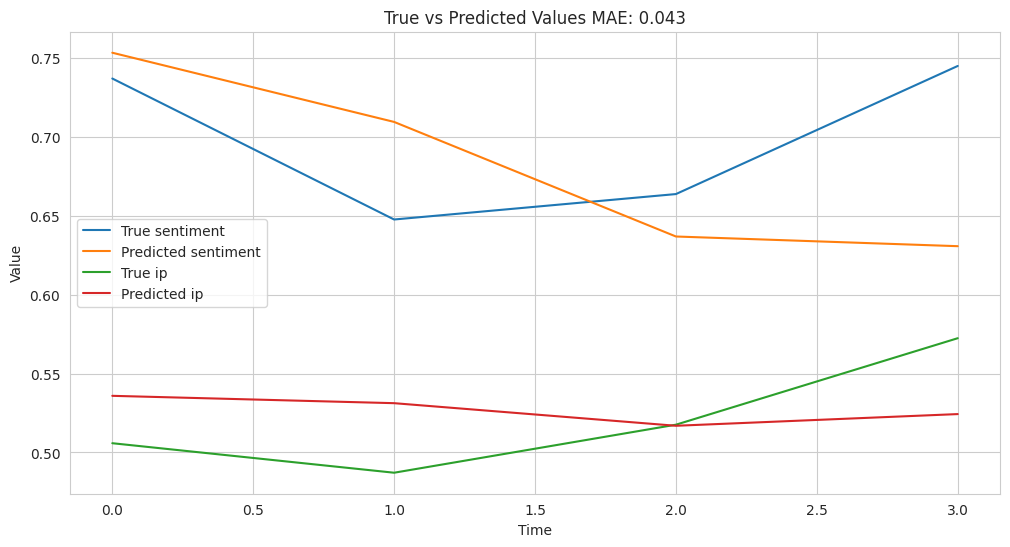

In [64]:

# Visualizar las series temporales originales y las predicciones del modelo
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='True sentiment')
plt.plot(modelo_cargado_predictions[:, 0], label='Predicted sentiment')
plt.plot(y_test[:, 1], label='True ip')
plt.plot(modelo_cargado_predictions[:, 1], label='Predicted ip')
plt.title(f'True vs Predicted Values MAE: {mae_modelo_cargado:.3f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()